# Policy gradient

Several policy gradient algorithms are implemented in this notebook:

* use parallel environment to collect batch


In [1]:
import gym
from gym import logger as gymlogger
gymlogger.set_level(40)

import random
import numpy as np
from collections import namedtuple, deque

from IPython import display
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.distributions import Categorical

from parallelEnv import parallelEnv

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [2]:
env = gym.make('Acrobot-v1')
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)
print(env.observation_space.low)
print(env.observation_space.high)

State shape:  (6,)
Number of actions:  3
[ -1.          -1.          -1.          -1.         -12.56637096
 -28.27433395]
[  1.           1.           1.           1.          12.56637096
  28.27433395]


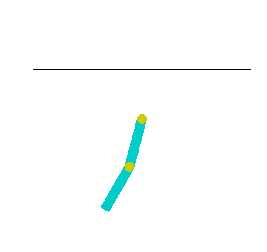

In [3]:
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(1000):
    action = env.action_space.sample()
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        break 

In [4]:
class Policy(nn.Module):
    def __init__(self, state_size = 6,  action_size = 3):
        super(Policy, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(state_size, 32),
            nn.ReLU(inplace = True),
            nn.Linear(32, action_size),
            nn.Softmax(dim = 1)
        )

    def forward(self, state):
        x = self.main(state)
        return x
    
def act(policy, state):
    state = torch.from_numpy(state).float().to(device)
    probs = policy(state).cpu()
    m = Categorical(probs)
    action = m.sample()
    log_prob =  m.log_prob(action)
    return action, log_prob

def collect_trajectories(envs, policy, tmax):
    # collect trajectories for a parallelized parallelEnv object
    policy.eval()
    reward_list = []
    log_prob_list = []
    
    state = envs.reset()
    for t in range(tmax):
        action, log_prob = act(policy, state)
        state, reward, done, _ = envs.step(action.numpy())
        reward_list.append(reward)
        log_prob_list.append(log_prob)
        if done.any():
            break

    return reward_list, log_prob_list

## 1. use parallel environment to collect batch

N sample estimate

\begin{equation}
L(\theta) =\frac{1}{N}\sum_{i=1}^N \sum_{t=0}^T \log\pi_{\theta}(a_{it}|s_{it})\sum_{t'=t}^T \gamma^{t'-t}r(s_{it'},a_{it'})
\end{equation}

Episode 100...sum of rewards -95.88
Episode 200...sum of rewards -76.88
Episode 300...sum of rewards -71.888
Episode 400...sum of rewards -89.888
Episode 500...sum of rewards -62.88
Episode 600...sum of rewards -86.88
Episode 700...sum of rewards -72.88
Episode 800...sum of rewards -69.88
Episode 900...sum of rewards -77.62
Episode 1000...sum of rewards -75.88


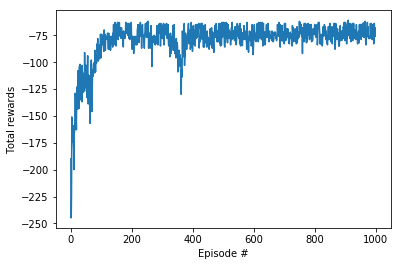

In [5]:
envs = parallelEnv('Acrobot-v1', n = 8)
n=len(envs.ps) # number of parallel instances

PRINT_EVERY = 100
NUM_EPISODES = 1000
TMAX = 500
GAMMA = 0.99

policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr = 0.01)
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma = 0.1)

score_list = []

for e in range(1, NUM_EPISODES+1):
    # collect a trajectory
    reward_list, log_prob_list = collect_trajectories(envs, policy, tmax=TMAX)
    policy.train()
    
    reward_array = np.asarray(reward_list)
    score = reward_array.sum(axis = 0).mean()
    score_list.append(score)
            
    # compute loss
    T = len(reward_list)
    L = []
    for t, log_prob in enumerate(log_prob_list):
        discounts = GAMMA**np.arange(T-t)
        reward_to_go = reward_array[t:,:]*discounts[:,np.newaxis]
        R = reward_to_go.sum(axis = 0)
        Lt = log_prob*torch.tensor(R).float() # element-wise multiply
        L.append(Lt.unsqueeze(0)) 

    loss = - torch.cat(L).sum(dim = 0).mean() # sum over steps; average over batches
    
    # update network 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print('\rEpisode {}...sum of rewards {:.2f}'.format(e,score), end = "")
    if e % PRINT_EVERY == 0:
        print('\rEpisode {}...sum of rewards {:.2f}'.format(e,score))
        scheduler.step()

score_list1 = score_list
fig = plt.figure()
plt.plot(np.arange(len(score_list)), score_list)
plt.ylabel('Total rewards')
plt.xlabel('Episode #')
plt.show()

## 2. reward normalizarion

\begin{equation}
    R_i\leftarrow \frac{R_i-\mu}{\sigma}, \quad \mu = \frac{1}{N}\sum_{i=1}^N R_i, \quad \sigma= \sqrt{\frac{1}{N}\sum_i(R_i-\mu)^2}
\end{equation}

Episode 100...sum of rewards -65.88
Episode 200...sum of rewards -65.88
Episode 300...sum of rewards -65.88
Episode 400...sum of rewards -65.88
Episode 500...sum of rewards -64.88
Episode 600...sum of rewards -64.88
Episode 700...sum of rewards -72.88
Episode 800...sum of rewards -64.88
Episode 900...sum of rewards -64.88
Episode 1000...sum of rewards -72.88


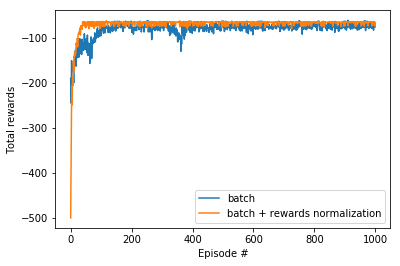

In [6]:
envs = parallelEnv('Acrobot-v1', n = 8)
n=len(envs.ps) # number of parallel instances

PRINT_EVERY = 100
NUM_EPISODES = 1000
TMAX = 500
GAMMA = 0.99

policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr = 0.01)
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma = 0.1)

score_list = []

for e in range(1, NUM_EPISODES+1):
    # collect a trajectory
    reward_list, log_prob_list = collect_trajectories(envs, policy, tmax=TMAX)
    policy.train()
    
    reward_array = np.asarray(reward_list)
    score = reward_array.sum(axis = 0).mean()
    score_list.append(score)
            
    # compute loss
    T = len(reward_list)
    L = []
    for t, log_prob in enumerate(log_prob_list):
        discounts = GAMMA**np.arange(T-t)
        reward_to_go = reward_array[t:,:]*discounts[:,np.newaxis]
        R = reward_to_go.sum(axis = 0)
        mean = np.mean(R)
        std = np.std(R) + 1.0e-10
        R_normalized = (R - mean)/std
        Lt = log_prob*torch.tensor(R_normalized).float() # element-wise multiply
        L.append(Lt.unsqueeze(0)) 

    loss = - torch.cat(L).sum(dim = 0).mean() # sum over steps; average over batches
    
    # update network 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print('\rEpisode {}...sum of rewards {:.2f}'.format(e,score), end = "")
    if e % PRINT_EVERY == 0:
        print('\rEpisode {}...sum of rewards {:.2f}'.format(e,score))
        scheduler.step()

score_list2 = score_list
fig = plt.figure()
plt.plot(np.arange(len(score_list1)), score_list1, label = "batch")
plt.plot(np.arange(len(score_list2)), score_list2, label = "batch + rewards normalization")
plt.ylabel('Total rewards')
plt.xlabel('Episode #')
plt.legend()
plt.show()

In [7]:
torch.save(policy.state_dict(), "acrobot.pth")

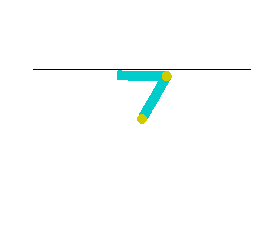

In [8]:
policy.eval()

img = plt.imshow(env.render(mode='rgb_array'))
state = env.reset()
for t in range(1000):
    state = state[np.newaxis,:] # add batch dim 
    action, _= act(policy, state)
    action = action.item()
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        break 

In [9]:
from gym.wrappers import Monitor
def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

env = wrap_env( gym.make('Acrobot-v1'))
env.seed(1234)

state = env.reset()
while True:
    env.render()
    state = state[np.newaxis,:] # add batch dim
    action, log_prob = act(policy, state)
    action = action.item()
    state, reward, done, _ = env.step(action)
    if done:
        break

env.close()